In [1]:
import logging
import numpy as np
from scipy.stats import norm
from os import environ
from IPython.display import display
import pandas as pd
# %matplotlib inline
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.datasets import MapDatasetOnOff, MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import RingBackgroundMaker, SafeMaskMaker, MapDatasetMaker,SpectrumDatasetMaker
from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom
from tqdm.auto import tqdm
from gammapy.modeling.models import PowerLawSpectralModel
from astroquery.simbad import Simbad
from gammapy.maps import MapCoord
log = logging.getLogger(__name__)

In [2]:
import seaborn as sns
sns.set_theme(font="Serif",font_scale=2,style='ticks',context='paper',palette='pastel')

In [92]:
datastore = DataStore.from_dir("/raid/romulus/swong/mydl3/zenodo/segue")
#datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [93]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon="83.633114 deg",
    lat="22.014487 deg",
    #lon=151.7633333,
    #lat=16.0736111,
    radius="2 deg",
)
selected_obs_table = datastore.obs_table#.select_observations(selection)

In [94]:
#obs_ids = [64080,64081,64082,64083]
observations = datastore.get_observations(selected_obs_table["OBS_ID"])
#observations = datastore.get_observations(obs_id=[64080])

73266


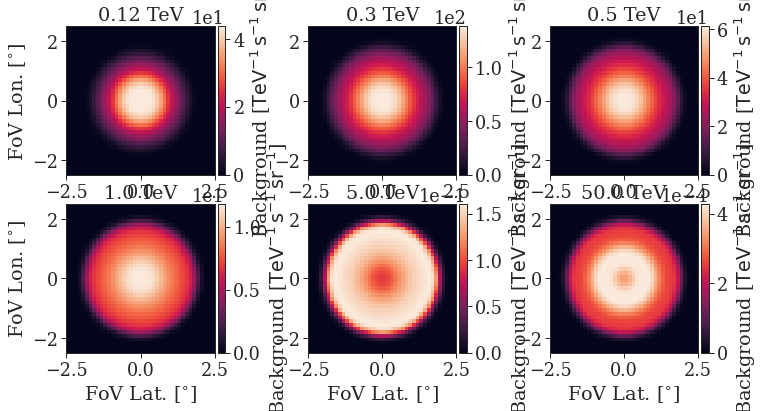

77021


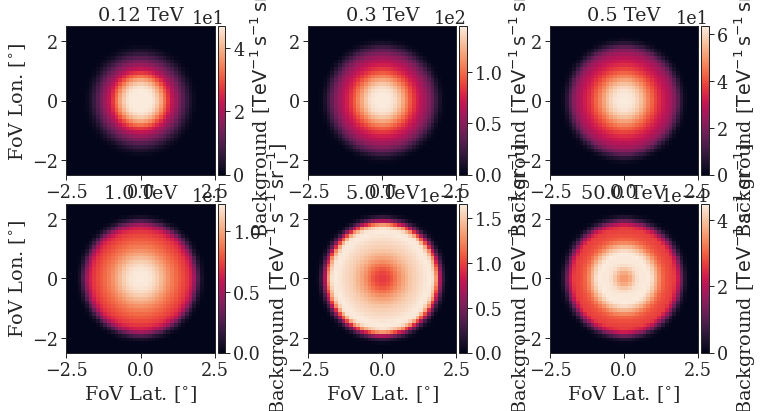

80190


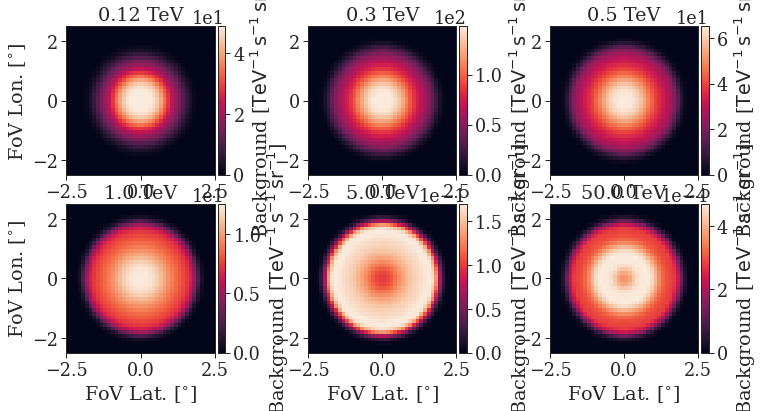

81437


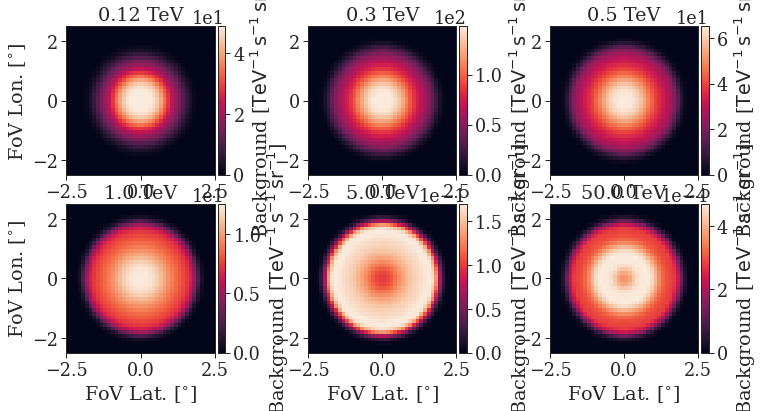

In [95]:
for obs in observations:
    print(obs.obs_id)
    #obs.bkg.peek()
    obs.bkg.plot_at_energy([0.12 * u.TeV,0.3*u.TeV,0.5*u.TeV,1*u.TeV,5*u.TeV,50*u.TeV])
    plt.show()

offsets = [0,0.25,0.5,0.75,1.,1.25,1.5,1.75,2.]
energies = np.logspace(-1,1,10)

for obs in observations:
    plt.figure(figsize=(8,6))
    obs.psf.plot_containment_radius_vs_energy(fraction=(0.68,), offset=offsets * u.deg)
    plt.axhline(np.sqrt(0.008),label='theta')
    plt.legend()
#plt.xlim(1e-1,3)

energies = np.logspace(-1,1.5,8) * u.TeV
dataframes = []

plt.figure(figsize=(10,7))
for energy in energies:
    rates = []
    for off in offsets:
        rate = observations[1].bkg.evaluate(offset=off*u.deg,energy=energy)
        rates.append(rate.value)
    #rates = rates/max(rates)
    plt.plot(offsets,rates,label=f'{energy:.2f}')
plt.legend(fontsize=10,loc='upper right')
plt.show()

In [106]:
source_pos = SkyCoord(151.7633333,16.0736111,unit='deg')
#source_pos = SkyCoord(83.6333,22.0145,unit='deg')

In [107]:
energy_axis = MapAxis.from_energy_bounds(0.1, 100, 10, unit="TeV")
# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100.0, 200, unit="TeV", name="energy_true"
)
geom = WcsGeom.create(
    skydir=(source_pos.ra.value, source_pos.dec.value),
    binsz=0.01,
    width=(4, 4),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [129]:
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields('ra', 'dec', "flux(B)", "flux(V)", "jp11")
simbad.remove_votable_fields('coordinates')

srcs_tab = simbad.query_region(source_pos, radius=1.5*u.deg)
srcs_tab = srcs_tab[srcs_tab["FLUX_B"]<8]
srcs_tab = srcs_tab[srcs_tab["FLUX_V"]!=np.ma.masked]
srcs_tab

MAIN_ID,RA,DEC,FLUX_B,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",mag,mag,
object,str13,str13,float32,float32,int32
HD 87500,10 05 40.9256,+15 45 27.031,6.733,6.36,1
* eta Leo,10 07 19.9523,+16 45 45.587,3.39,3.41,1
HD 87776,10 07 39.3388,+15 09 27.297,7.77,7.14,1


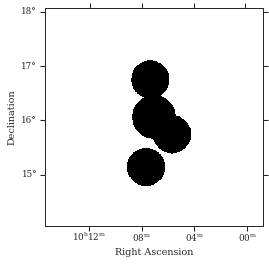

In [130]:
# Make the exclusion mask
geom_image = geom.to_image().to_cube([energy_axis.squash()])

regions = CircleSkyRegion(center=source_pos, radius=0.4 * u.deg)
all_ex = [regions]
stars = []
for star in srcs_tab:
    pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
    star = CircleSkyRegion(center=pos, radius=0.35 * u.deg)
    stars.append(star)
    all_ex.append(star)

exclusion_mask = ~geom_image.region_mask(all_ex)
exclusion_mask.sum_over_axes().plot()
plt.show()

In [161]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="stacked"
)

In [162]:
offset_max = 1.75 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max","bkg-peak"], offset_max=offset_max,
)

for obs in tqdm(observations):
    dataset = maker.run(stacked,obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)

  0%|          | 0/4 [00:00<?, ?it/s]

In [163]:
ring_maker = RingBackgroundMaker(
    r_in="0.53 deg", width="0.14 deg", exclusion_mask=exclusion_mask
)
dataset_on_off = ring_maker.run(stacked)

In [164]:
pl = PowerLawSpectralModel(index=2.4,amplitude=3.16e-11*u.Unit("TeV-1 s-1 cm-2"))

/homes/wang/swong/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


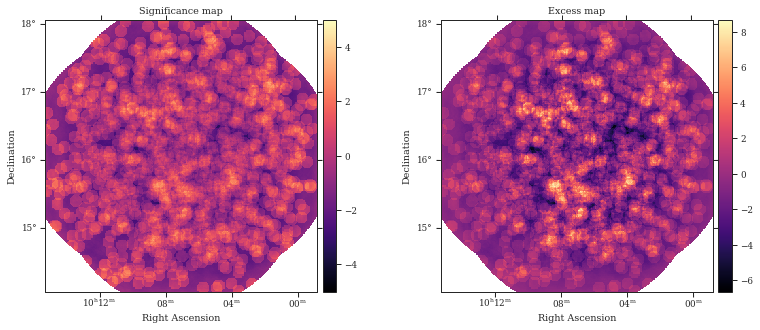

In [165]:
#estimator = ExcessMapEstimator(0.15 * u.deg, selection_optional=[],correlate_off=False)
estimator = ExcessMapEstimator(np.sqrt(0.008) * u.deg, selection_optional=["alpha"],correlate_off=False,
                               #gamma_min_sensitivity=10,bkg_syst_fraction_sensitivity=0.05,
                               #apply_threshold_sensitivity=False,
                               #spectral_model = pl,
                               #sum_over_energy_groups=True,
                               )
lima_maps = estimator.run(dataset_on_off)

significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

my_cmap = sns.color_palette("magma", as_cmap=True)

# We can plot the excess and significance maps
fig, (ax1, ax2) = plt.subplots(
    figsize=(13, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)
ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True,cmap=my_cmap,vmin=-5,vmax=5)

# for star in srcs_tab:
    
ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True,cmap=my_cmap)
plt.show()

<WCSAxes: >

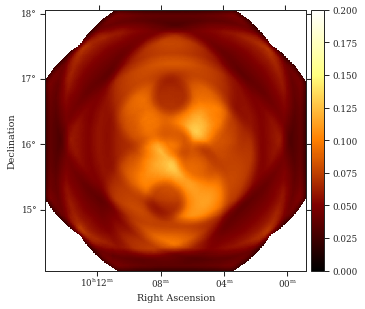

In [166]:
plt.figure(figsize=(5,5))
alpha_map = lima_maps['alpha']
alpha_map.plot(add_cbar=True,vmin=0,vmax=0.2)

Fit results: mu = -0.12, std = 1.03


Text(-4.5, 0.5, 'Fit results: mu = -0.12, std = 1.03')

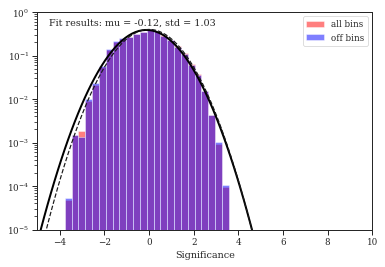

In [167]:
sns.set_theme(font="Serif",style='ticks',context='paper',palette='pastel')
significance_map_off = significance_map * exclusion_mask

# significance distribution
significance_all = significance_map.data[np.isfinite(significance_map.data)].flatten()
significance_off = significance_map_off.data[exclusion_mask & np.isfinite(significance_map_off.data)].flatten()

fig, ax = plt.subplots()
ax.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=np.linspace(-5,10,50),
)

ax.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=np.linspace(-5,10,50),
)

# Now, fit the off distribution with a Gaussian
def gauss(x,a,b,c):
    return 1/(np.sqrt(2*np.pi)*c) * np.exp((-(x-b)**2)/(2*c**2))

#from scipy.optimize import curve_fit
#popt,pcov = curve_fit(gauss,(off[1][1:]+off[1][:-1])/2,off[0])
#print(popt)

mu, std = norm.fit(significance_off)
x = np.linspace(-5, 10, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, lw=2, color="black")
ax.plot(x,norm.pdf(x,0,1),color='k',ls='--')
#ax.plot(x,gauss(x,*popt))

ax.legend()
ax.set_xlabel("Significance")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1)
# xmin, xmax = np.min(significance_all), np.max(significance_all)
ax.set_xlim(-5, 10)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")
ax.text(-4.5, 0.5, f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

In [150]:
#analysis_pos = SkyCoord(source_pos.ra.value * u.deg, source_pos.dec.value *u.deg- 0.5 * u.deg)
analysis_pos = MapCoord.create((0, 0))

In [244]:
from astropy.io import fits
hdul = fits.open('/raid/romulus/swong/data/analysis/Results/v490/crabtestrbm/Crab.fits')
skymap = hdul[5].data

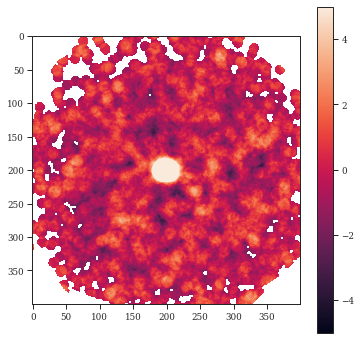

In [245]:
plt.figure(figsize=(6,6))


plt.imshow(skymap,vmin=-5,vmax=5)
plt.colorbar()

Text(0.5, 1.0, 'Gammapy - VERITAS')

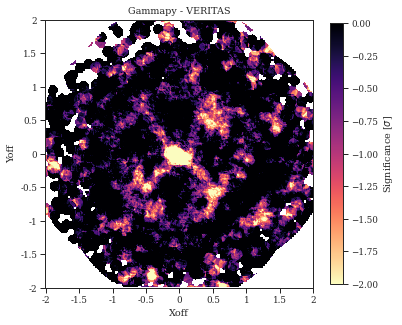

In [248]:
plt.figure(figsize=(6,6))

plt.imshow(significance_map.data[0,:,:] - skymap,vmin=-2,vmax=0,cmap='magma_r')
plt.colorbar(label=r"Significance [$\sigma$]",shrink=0.8)
ndeg = 2
r = ndeg/0.01
circle = plt.Circle((200,200), r ,fill = False,color='k',lw=1,ls='--',label=f'r={ndeg} deg')
plt.yticks(np.linspace(0,len(significance_map.data[0,0,:]),9),[2,1.5,1,0.5,0,-0.5,-1,-1.5,-2])
plt.xticks(np.linspace(0,len(significance_map.data[0,0,:]),9),[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
plt.xlabel('Xoff')
plt.ylabel('Yoff')
ax.add_patch(circle)
plt.title('Gammapy - VERITAS')
#plt.legend(loc='upper right')